In [1]:
# Import Required Libraries
from matplotlib import pyplot as plt
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier

import seaborn as sn
import pandas as pd

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Set Up Classification Models
- gnb = Gaussian Naive Bayes
- base_t = Default Decision tree
- per = Perceptron
- base_mlp = Default Multi-Layer Perceptron

In [2]:
# Import Models
import csv
gnb = GaussianNB()
base_t = tree.DecisionTreeClassifier(criterion="entropy")
per = Perceptron()
base_mlp = MLPClassifier(hidden_layer_sizes=(100,), activation="logistic", solver="sgd")

# Debug
debug = False

# Data Imports
### Imports the data from data 1 and data 2

In [3]:
# Import Data
test_data_1 = np.genfromtxt('./data 1/test_no_label_1.csv', delimiter=',')
test_data_2 = np.genfromtxt('./data 2/test_no_label_2.csv', delimiter=',')

labeled_test_data_1 = np.genfromtxt('./data 1/test_with_label_1.csv', delimiter=',')
labeled_test_data_2 = np.genfromtxt('./data 2/test_with_label_2.csv', delimiter=',')

train_data_1 = np.genfromtxt('./data 1/train_1.csv', delimiter=',')
train_data_2 = np.genfromtxt('./data 2/train_2.csv', delimiter=',')

val_data_1 = np.genfromtxt('./data 1/val_1.csv', delimiter=',')
val_data_2 = np.genfromtxt('./data 2/val_2.csv', delimiter=',')

x_train_1 = train_data_1[ :, :-1]
y_train_1 = train_data_1[ :, -1]

x_test_1 = labeled_test_data_1[ :, :-1]
y_test_1 = labeled_test_data_1[ :, -1]

x_train_2 = train_data_2[ :, :-1]
y_train_2 = train_data_2[ :, -1]

x_test_2 = labeled_test_data_2[ :, :-1]
y_test_2 = labeled_test_data_2[ :, -1]

# Reference Dictionaries
### Sets up dictionaries to translate values to symbolic names ({0 : 'A', 1 : 'B', etc}

In [4]:
# Get Value Dictionaries
data_1 = {}
data_2 = {}

def readAndTranslate(inputFile, data_ref):
    with open(inputFile, mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, None) # Skip header
    for rows in reader:
        data_ref[int(rows[0])] = rows[1]

readAndTranslate('data 1/info_1.csv', data_1)
readAndTranslate('data 2/info_2.csv', data_2)

# Plotting Utility Method
### Reusable method to return a scatter plot of frequency distributions for a given data set
- takes a dataset as input, and the plot title
    - gets labels for dataset by extracting last column of each row: data_labels
    - generates a tuple (count, label) for each label found
    - reduces list of tuples to a set to get one of each label only
    - assigns labels to x axis on data_x and counts to y axis on data_y

In [5]:
# Distribution Plot Methods
def distribution(data, title, ref):
    data_labels = [ref[(row[-1])] for row in data]
    tuples = sorted(set([(label, data_labels.count(label)) for label in data_labels]))
    
    if debug: 
        print(tuples)
    
    data_x = [x[0] for x in tuples]
    data_y = [y[1] for y in tuples]
    
    plt.scatter(data_x, data_y)
    plt.xlabel("Classes")
    plt.ylabel("Frequencies")
    plt.title(title)
    plt.show()

# Distributions for Data 1 and Data 2
- Training Set
- Labeled Test Set
- Validation Set

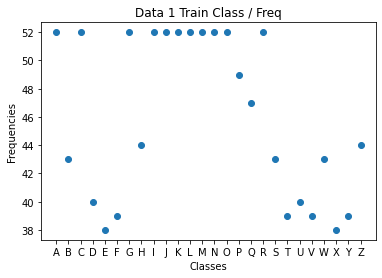

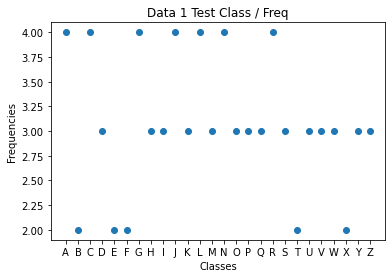

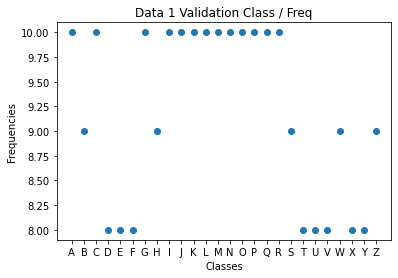

In [6]:
# Distributions for Data 1
distribution(train_data_1, "Data 1 Train Class / Freq", data_1)
distribution(labeled_test_data_1, "Data 1 Test Class / Freq", data_1)
distribution(val_data_1, "Data 1 Validation Class / Freq", data_1)

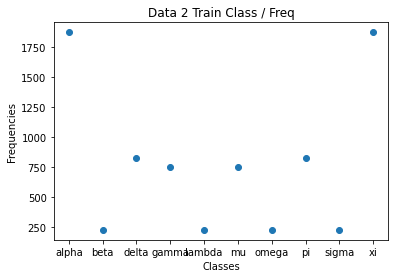

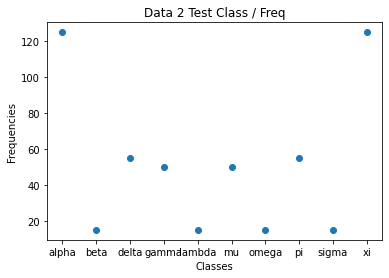

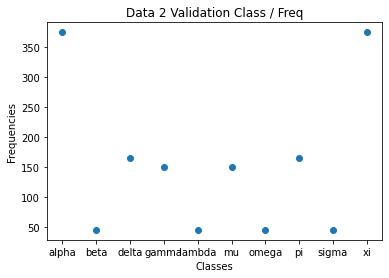

In [7]:
# Distributions for Data 2
distribution(train_data_2, "Data 2 Train Class / Freq", data_2)
distribution(labeled_test_data_2, "Data 2 Test Class / Freq", data_2)
distribution(val_data_2, "Data 2 Validation Class / Freq", data_2)

# General Model Testing/Training Procedure (Supervised)
### Training
- Split training data into features vectors (x_train) and label vector (y_train)
- Fit data to the model

### Testing
- Split test data into features vector (x_test) and label vector (y_test)
- Get label classification vector from trained model (prediction)

### Output
- Print actual labels
- Print model label predictions
- Print model label predictions to csv file
- Print prediction misses (comparision between prediction and y_test)
- Compare model label classification vector (prediction) to label vector (y_test)
    

# Gaussian Naive Bayes

Accuracy: 68.75%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


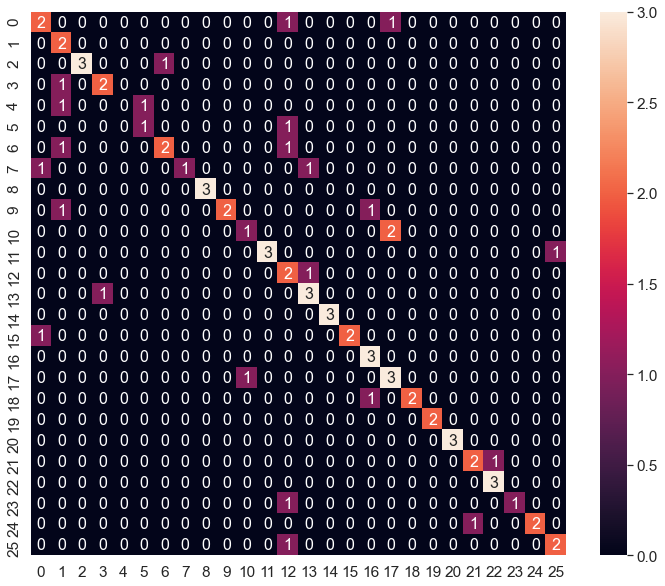


Classification report:
              precision    recall  f1-score   support

         0.0       0.50      0.50      0.50         4
         1.0       0.33      1.00      0.50         2
         2.0       1.00      0.75      0.86         4
         3.0       0.67      0.67      0.67         3
         4.0       0.00      0.00      0.00         2
         5.0       0.50      0.50      0.50         2
         6.0       0.67      0.50      0.57         4
         7.0       1.00      0.33      0.50         3
         8.0       1.00      1.00      1.00         3
         9.0       1.00      0.50      0.67         4
        10.0       0.50      0.33      0.40         3
        11.0       1.00      0.75      0.86         4
        12.0       0.29      0.67      0.40         3
        13.0       0.60      0.75      0.67         4
        14.0       1.00      1.00      1.00         3
        15.0       1.00      0.67      0.80         3
        16.0       0.60      1.00      0.75         3
   

In [8]:
# GNB-DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

gnb.fit(x_train, y_train)

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

prediction = gnb.predict(x_test)
if debug:
    print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

      
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/GNB-DS1.csv', index= True)

# write the predictions
with open('output/GNB-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/GNB-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
GNB1Report = classification_report(y_test, prediction)
print(GNB1Report)
GNB1Report = classification_report(y_test, prediction, output_dict=True)

Accuracy: 66.92307692307692%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


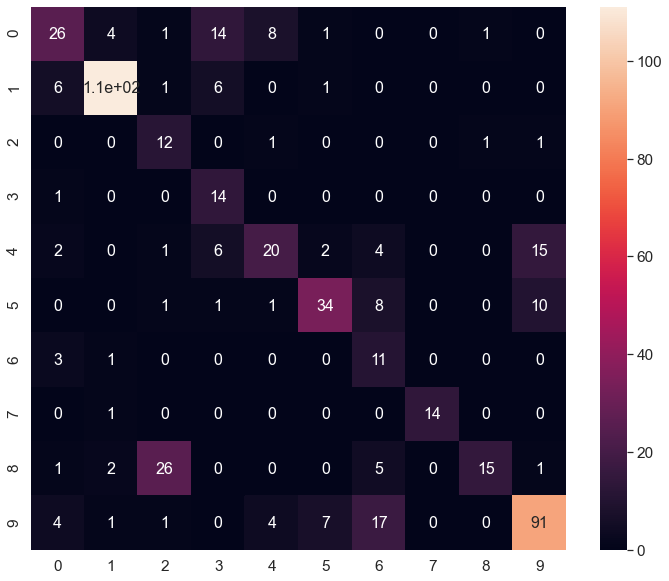


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.47      0.53        55
         1.0       0.93      0.89      0.91       125
         2.0       0.28      0.80      0.41        15
         3.0       0.34      0.93      0.50        15
         4.0       0.59      0.40      0.48        50
         5.0       0.76      0.62      0.68        55
         6.0       0.24      0.73      0.37        15
         7.0       1.00      0.93      0.97        15
         8.0       0.88      0.30      0.45        50
         9.0       0.77      0.73      0.75       125

    accuracy                           0.67       520
   macro avg       0.64      0.68      0.60       520
weighted avg       0.75      0.67      0.68       520



In [9]:
# GNB-DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

gnb.fit(x_train, y_train)

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

prediction = gnb.predict(x_test)
if debug:
    print([(entry, data_2[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_2[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

      
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/GNB-DS2.csv', index= True)

# write the predictions
with open('output/GNB-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/GNB-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
GNB2Report = classification_report(y_test, prediction)
print(GNB2Report)
GNB2Report = classification_report(y_test, prediction, output_dict=True)

# Baseline Decision Trees
### Parameters
- splitting criterion: entropy
- maximum depth: none
- min # of samples to split an internal node: 2
- min impurity decrease: 0.0
- class weight: none

Accuracy: 48.75%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


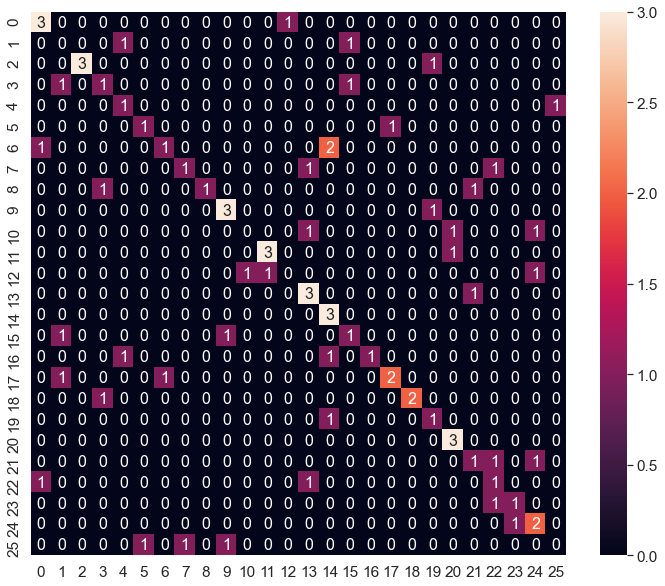


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.00      0.00      0.00         2
         2.0       1.00      0.75      0.86         4
         3.0       0.33      0.33      0.33         3
         4.0       0.33      0.50      0.40         2
         5.0       0.50      0.50      0.50         2
         6.0       0.50      0.25      0.33         4
         7.0       0.50      0.33      0.40         3
         8.0       1.00      0.33      0.50         3
         9.0       0.60      0.75      0.67         4
        10.0       0.00      0.00      0.00         3
        11.0       0.75      0.75      0.75         4
        12.0       0.00      0.00      0.00         3
        13.0       0.50      0.75      0.60         4
        14.0       0.43      1.00      0.60         3
        15.0       0.33      0.33      0.33         3
        16.0       1.00      0.33      0.50         3
   

In [10]:
# Base-DT-DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

base_t.fit(x_train, y_train)

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

prediction = base_t.predict(x_test)
if debug:
    print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

      
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Base-DT-DS1.csv', index= True)

# write the predictions
with open('output/Base-DT-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Base-DT-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BaseDT1Report = classification_report(y_test, prediction)
print(BaseDT1Report)
BaseDT1Report = classification_report(y_test, prediction, output_dict=True)


Accuracy: 76.34615384615384%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


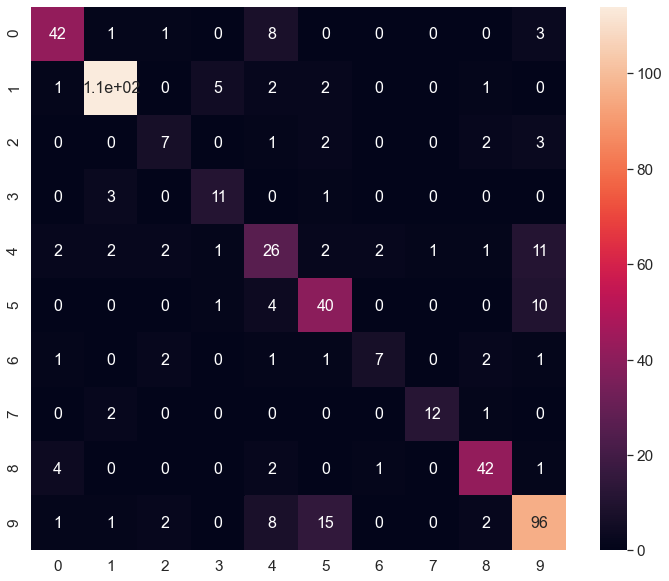


Classification report:
              precision    recall  f1-score   support

         0.0       0.82      0.76      0.79        55
         1.0       0.93      0.91      0.92       125
         2.0       0.50      0.47      0.48        15
         3.0       0.61      0.73      0.67        15
         4.0       0.50      0.52      0.51        50
         5.0       0.63      0.73      0.68        55
         6.0       0.70      0.47      0.56        15
         7.0       0.92      0.80      0.86        15
         8.0       0.82      0.84      0.83        50
         9.0       0.77      0.77      0.77       125

    accuracy                           0.76       520
   macro avg       0.72      0.70      0.71       520
weighted avg       0.77      0.76      0.76       520



In [11]:
# Base-DT-DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

base_t.fit(x_train, y_train)

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

prediction = base_t.predict(x_test)
if debug:
    print([(entry, data_2[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_2[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

        
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Base-DT-DS2.csv', index= True)

# write the predictions
with open('output/Base-DT-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Base-DT-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BaseDT2Report = classification_report(y_test, prediction)
print(BaseDT2Report)
BaseDT2Report = classification_report(y_test, prediction, output_dict=True)

# Optimized Decision Trees
### Parameters
- splitting criterion: gini / entropy
- maximum depth: 10 / no max
- min # of samples to split an internal node: range(1/10^100 - 1/10^110)
- min impurity decrease: range(1/10^100 - 1/10^110)
- class weight: none / balanced
### Brute Force Optimization Process
- Trains new tree with different h-parameter to determine best performance
    - Loops through a variety of parameters, tracking the best case of predictions misses (best)
- Findings
    - Entropy as a split criterion is the best h-parameter
    - No max depth for the tree is the best h-parameter
    - Balanced class weights is the best h-parameter
    - Min Samples Split works best at very small numbers
        - testing with range down to 1/100000
    - Min Impurity Decrease works best at very small numbers
        - testing with range down to 1/100000

Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-100
Class Weights: Balanced
Accuracy: 42.67782426778243%
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-101
Class Weights: Balanced
Accuracy: 43.09623430962343%
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-102
Class Weights: Balanced
Accuracy: 45.60669456066945%
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-102
Min Impurity Decrease:1e-102
Class Weights: Balanced
Accuracy: 46.44351464435147%
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-104
Min Impurity Decrease:1e-104
Class Weights: Balanced
Accuracy: 47.69874476987448%


Accuracy: 53.75%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


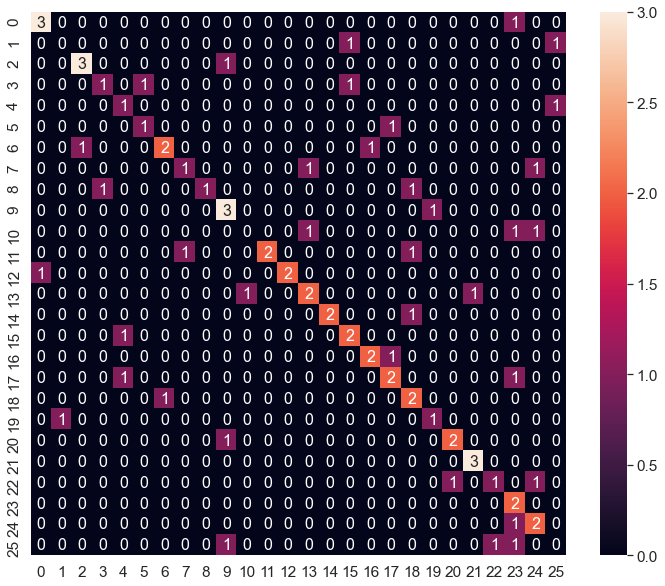


Classification report:
              precision    recall  f1-score   support

         0.0       0.75      0.75      0.75         4
         1.0       0.00      0.00      0.00         2
         2.0       0.75      0.75      0.75         4
         3.0       0.50      0.33      0.40         3
         4.0       0.33      0.50      0.40         2
         5.0       0.50      0.50      0.50         2
         6.0       0.67      0.50      0.57         4
         7.0       0.50      0.33      0.40         3
         8.0       1.00      0.33      0.50         3
         9.0       0.50      0.75      0.60         4
        10.0       0.00      0.00      0.00         3
        11.0       1.00      0.50      0.67         4
        12.0       1.00      0.67      0.80         3
        13.0       0.50      0.50      0.50         4
        14.0       1.00      0.67      0.80         3
        15.0       0.50      0.67      0.57         3
        16.0       0.67      0.67      0.67         3
   

In [12]:
# Tree Optimization DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

x_val = val_data_1[ :, :-1]
y_val = val_data_1[ :, -1]

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

best = 239

def tree_score(sample, impurity):
    best_tree = tree.DecisionTreeClassifier(criterion="entropy", # Entropy is the best split criterion
                                       max_depth=None, # No max depth is best h-parameter
                                       min_samples_split=sample, # Small numbers here for best predictions
                                       min_impurity_decrease=impurity, # Small numbers here for best predictions
                                       class_weight="balanced") # Balanced class weights is the best h-paramter
    best_tree.fit(x_train, y_train)
    pred = best_tree.predict(x_val)
    return (y_val != pred).sum()

tuned_samples = 0
tuned_impurities = 0

for samples in [1/(10**x) for x in range(100, 110, 1)]: # Min Number of Samples
    for impurities in [1/(10**y) for y in range(100, 110, 1)]: # Min Impurity 
        # Decrease
            missed = tree_score(samples, impurities)
            if missed < best:
                print(f'Splitting Criterion: Entropy\n'
                      f'Max Depth: None\n'
                      f'Min # Samples: {samples}\n'
                      f'Min Impurity Decrease:{impurities}\n'
                      f'Class Weights: Balanced')
                tuned_samples = samples
                tuned_impurities = impurities
                best = missed
                print(f'Accuracy: {100-(100*missed/239)}%')
            
tuned = tree.DecisionTreeClassifier(criterion="entropy", # Entropy is the best split criterion
                                       max_depth=None, # No max depth is best h-parameter
                                       min_samples_split=tuned_samples, # Small numbers here for best predictions
                                       min_impurity_decrease=tuned_impurities, # Small numbers here for best predictions
                                       class_weight="balanced")

prediction = tuned.fit(x_train, y_train).predict(x_test)
print(f'\n\nAccuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

        
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Best-DT-DS1.csv', index= True)

# write the predictions
with open('output/Best-DT-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Best-DT-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BestDT1Report = classification_report(y_test, prediction)
print(BestDT1Report)
BestDT1Report = classification_report(y_test, prediction, output_dict=True)

Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-100
Class Weights: Balanced
Accuracy: 76.21794871794872%
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-100
Min Impurity Decrease:1e-102
Class Weights: Balanced
Accuracy: 76.92307692307692%
Splitting Criterion: Entropy
Max Depth: None
Min # Samples: 1e-109
Min Impurity Decrease:1e-107
Class Weights: Balanced
Accuracy: 76.98717948717949%


Accuracy: 76.73076923076924%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


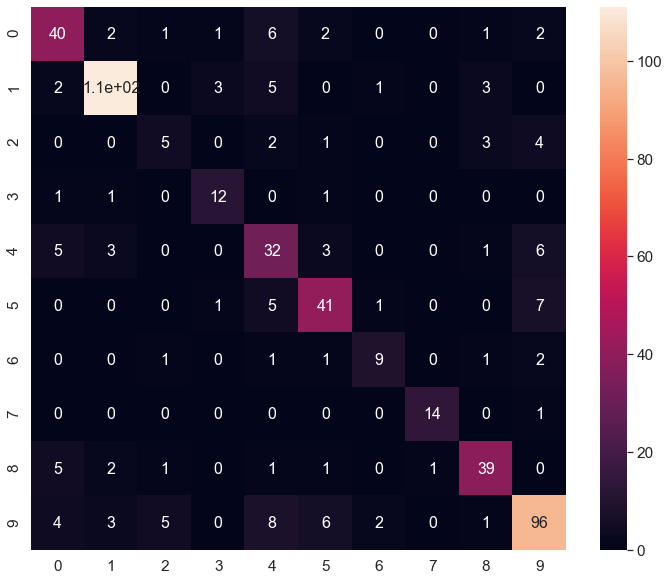


Classification report:
              precision    recall  f1-score   support

         0.0       0.70      0.73      0.71        55
         1.0       0.91      0.89      0.90       125
         2.0       0.38      0.33      0.36        15
         3.0       0.71      0.80      0.75        15
         4.0       0.53      0.64      0.58        50
         5.0       0.73      0.75      0.74        55
         6.0       0.69      0.60      0.64        15
         7.0       0.93      0.93      0.93        15
         8.0       0.80      0.78      0.79        50
         9.0       0.81      0.77      0.79       125

    accuracy                           0.77       520
   macro avg       0.72      0.72      0.72       520
weighted avg       0.77      0.77      0.77       520



In [13]:
# Tree Optimization DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

x_val = val_data_2[ :, :-1]
y_val = val_data_2[ :, -1]

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

best = 1560

tuned_samples = 0
tuned_impurities = 0

for samples in [1/(10**x) for x in range(100, 110, 1)]: # Min Number of Samples
    for impurities in [1/(10**y) for y in range(100, 110, 1)]: # Min Impurity 
        # Decrease
            missed = tree_score(samples, impurities)
            if missed < best:
                print(f'Splitting Criterion: Entropy\n'
                      f'Max Depth: None\n'
                      f'Min # Samples: {samples}\n'
                      f'Min Impurity Decrease:{impurities}\n'
                      f'Class Weights: Balanced')
                tuned_samples = samples
                tuned_impurities = impurities
                best = missed
                print(f'Accuracy: {100-(100*(missed/1560))}%')

tuned = tree.DecisionTreeClassifier(criterion="entropy", # Entropy is the best split criterion
                                       max_depth=None, # No max depth is best h-parameter
                                       min_samples_split=tuned_samples, # Small numbers here for best predictions
                                       min_impurity_decrease=tuned_impurities, # Small numbers here for best predictions
                                       class_weight="balanced")

prediction = tuned.fit(x_train, y_train).predict(x_test)
print(f'\n\nAccuracy: {100*((y_test == prediction).sum()/len(y_test))}%')
  

# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Best-DT-DS2.csv', index= True)

# write the predictions
with open('output/Best-DT-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Best-DT-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BestDT2Report = classification_report(y_test, prediction)
print(BestDT2Report)
BestDT2Report = classification_report(y_test, prediction, output_dict=True)

# Perceptrons

Accuracy: 77.5%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


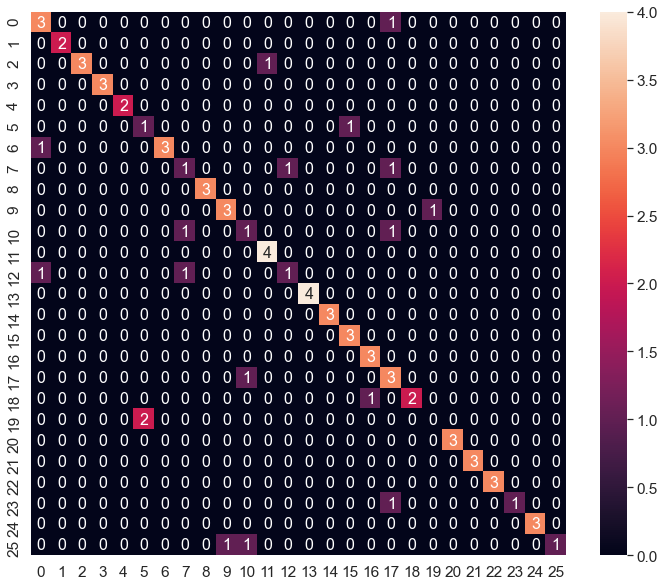


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       1.00      1.00      1.00         2
         2.0       1.00      0.75      0.86         4
         3.0       1.00      1.00      1.00         3
         4.0       1.00      1.00      1.00         2
         5.0       0.33      0.50      0.40         2
         6.0       1.00      0.75      0.86         4
         7.0       0.33      0.33      0.33         3
         8.0       1.00      1.00      1.00         3
         9.0       0.75      0.75      0.75         4
        10.0       0.33      0.33      0.33         3
        11.0       0.80      1.00      0.89         4
        12.0       0.50      0.33      0.40         3
        13.0       1.00      1.00      1.00         4
        14.0       1.00      1.00      1.00         3
        15.0       0.75      1.00      0.86         3
        16.0       0.75      1.00      0.86         3
   

In [14]:
#PER-DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

per.fit(x_train, y_train)

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

prediction = per.predict(x_test)
if debug:
    print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')


# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/PER-DS1.csv', index= True)

# write the predictions
with open('output/PER-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/PER-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
PER1Report = classification_report(y_test, prediction)
print(PER1Report)
PER1Report = classification_report(y_test, prediction, output_dict=True)

Accuracy: 83.84615384615385%

Confusion matrix:


/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


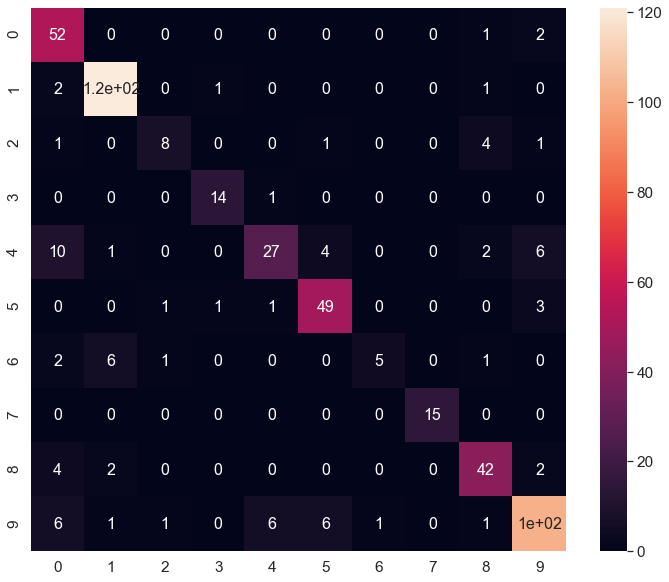


Classification report:
              precision    recall  f1-score   support

         0.0       0.68      0.95      0.79        55
         1.0       0.92      0.97      0.95       125
         2.0       0.73      0.53      0.62        15
         3.0       0.88      0.93      0.90        15
         4.0       0.77      0.54      0.64        50
         5.0       0.82      0.89      0.85        55
         6.0       0.83      0.33      0.48        15
         7.0       1.00      1.00      1.00        15
         8.0       0.81      0.84      0.82        50
         9.0       0.88      0.82      0.85       125

    accuracy                           0.84       520
   macro avg       0.83      0.78      0.79       520
weighted avg       0.84      0.84      0.83       520



In [15]:
#PER-DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

per.fit(x_train, y_train)

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

prediction = per.predict(x_test)
if debug:
    print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

      
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/PER-DS2.csv', index= True)

# write the predictions
with open('output/PER-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/PER-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
PER2Report = classification_report(y_test, prediction)
print(PER2Report)
PER2Report = classification_report(y_test, prediction, output_dict=True)

# Baseline Multilayer Perceptrons
### Parameters
- 1 hidden layer of 100 neurons
- logistic as activation function
- stochastic gradient descent
- default values for the rest of the parameters

/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy: 40.0%

Confusion matrix:


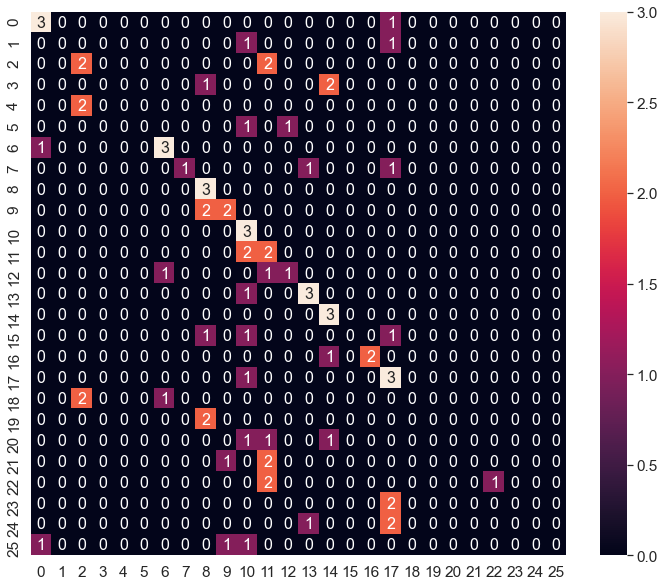


Classification report:
              precision    recall  f1-score   support

         0.0       0.60      0.75      0.67         4
         1.0       0.00      0.00      0.00         2
         2.0       0.33      0.50      0.40         4
         3.0       0.00      0.00      0.00         3
         4.0       0.00      0.00      0.00         2
         5.0       0.00      0.00      0.00         2
         6.0       0.60      0.75      0.67         4
         7.0       1.00      0.33      0.50         3
         8.0       0.33      1.00      0.50         3
         9.0       0.50      0.50      0.50         4
        10.0       0.25      1.00      0.40         3
        11.0       0.20      0.50      0.29         4
        12.0       0.50      0.33      0.40         3
        13.0       0.60      0.75      0.67         4
        14.0       0.43      1.00      0.60         3
        15.0       0.00      0.00      0.00         3
        16.0       1.00      0.67      0.80         3
   

In [16]:
#Base-MLP-DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

base_mlp.fit(x_train, y_train)

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

prediction = base_mlp.predict(x_test)
if debug:
    print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')


# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Base-MLP-DS1.csv', index= True)

# write the predictions
with open('output/Base-MLP-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Base-MLP-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BaseMLP1Report = classification_report(y_test, prediction)
print(BaseMLP1Report)
BaseMLP1Report = classification_report(y_test, prediction, output_dict=True)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Accuracy: 83.26923076923077%

Confusion matrix:


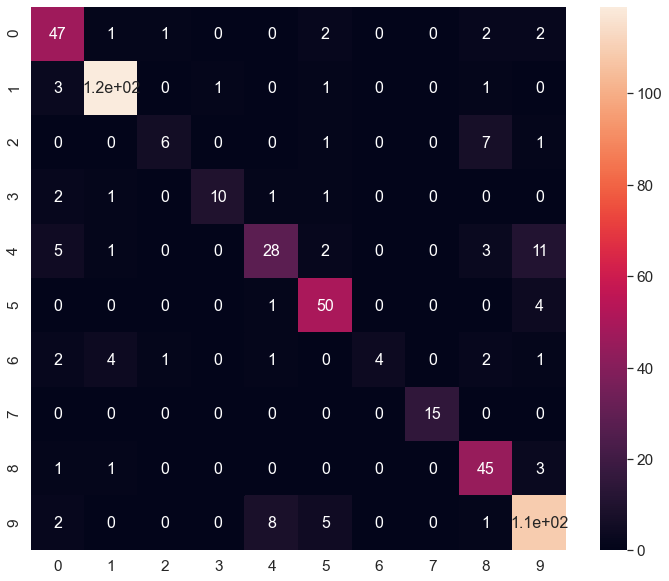


Classification report:
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80        55
         1.0       0.94      0.95      0.94       125
         2.0       0.75      0.40      0.52        15
         3.0       0.91      0.67      0.77        15
         4.0       0.72      0.56      0.63        50
         5.0       0.81      0.91      0.85        55
         6.0       1.00      0.27      0.42        15
         7.0       1.00      1.00      1.00        15
         8.0       0.74      0.90      0.81        50
         9.0       0.83      0.87      0.85       125

    accuracy                           0.83       520
   macro avg       0.84      0.74      0.76       520
weighted avg       0.84      0.83      0.82       520



In [17]:
#Base-MLP-DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

base_mlp.fit(x_train, y_train)

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

prediction = base_mlp.predict(x_test)
if debug:
    print([(entry, data_1[prediction[entry]]) for entry in range(prediction.size)])
    print([(entry, data_1[y_test[entry]]) for entry in range(y_test.size)])
print(f'Accuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

  
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Base-MLP-DS2.csv', index= True)

# write the predictions
with open('output/Base-MLP-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Base-MLP-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BaseMLP2Report = classification_report(y_test, prediction)
print(BaseMLP2Report)
BaseMLP2Report = classification_report(y_test, prediction, output_dict=True)

# Optimized Multilayer Perceptrons
### Paramters
- 2 hidden layers with 30+50 nodes / 3 hidden layers with 10+10 nodes
- logistic/tanh/relu/identity as activation function
- stochastic gradient descent / Adam
- default values for the rest of the parameters
### Brute Force Optimization Process
- Trains new MLP with different h-parameter to determine best performance
    - Loops through a variety of parameters, tracking the best case of predictions misses (best)

Layers: (30, 50)
Activation Function: logistic
Solver: sgd
Accuracy: 5.0209205020920535%


/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Layers: (30, 50)
Activation Function: logistic
Solver: adam
Accuracy: 80.3347280334728%


/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Layers: (30, 50)
Activation Function: tanh
Solver: adam
Accuracy: 80.75313807531381%


/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Layers: (30, 50)
Activation Function: relu
Solver: adam
Accuracy: 83.68200836820084%


/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_



Accuracy: 72.5%

Confusion matrix:


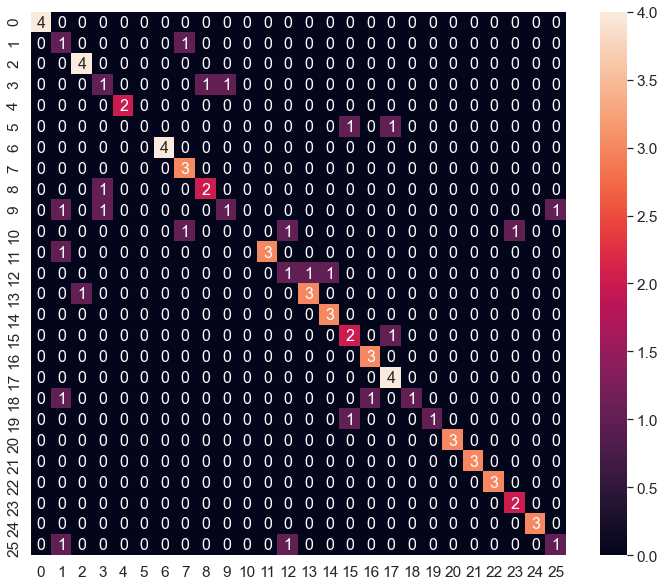


Classification report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         4
         1.0       0.20      0.50      0.29         2
         2.0       0.80      1.00      0.89         4
         3.0       0.33      0.33      0.33         3
         4.0       1.00      1.00      1.00         2
         5.0       0.00      0.00      0.00         2
         6.0       1.00      1.00      1.00         4
         7.0       0.60      1.00      0.75         3
         8.0       0.67      0.67      0.67         3
         9.0       0.50      0.25      0.33         4
        10.0       0.00      0.00      0.00         3
        11.0       1.00      0.75      0.86         4
        12.0       0.33      0.33      0.33         3
        13.0       0.75      0.75      0.75         4
        14.0       0.75      1.00      0.86         3
        15.0       0.50      0.67      0.57         3
        16.0       0.75      1.00      0.86         3
   

In [18]:
# MLP Optimization DS1
x_train = train_data_1[ :, :-1]
y_train = train_data_1[ :, -1]

x_val = val_data_1[ :, :-1]
y_val = val_data_1[ :, -1]

x_test = labeled_test_data_1[ :, :-1]
y_test = labeled_test_data_1[ :, -1]

best = 239

def mlp_score(layer, funct, solver):
    best_mlp = MLPClassifier(hidden_layer_sizes=layer, activation=funct, solver=solver)
    best_mlp.fit(x_train, y_train)
    pred = best_mlp.predict(x_val)
    return (y_val != pred).sum()

layers = [(30, 50), (10, 10, 10)]
functions = ["logistic", "tanh", "relu", "identity"]
solvers = ["sgd", "adam"]

tuned_layers = None
tuned_function = None
tuned_solver = None

for layer in layers:
    for function in functions:
        for solver in solvers:
            missed = mlp_score(layer, function, solver)
            if missed < best:
                print(f'Layers: {layer}\n'
                      f'Activation Function: {function}\n'
                      f'Solver: {solver}')
                tuned_layers = layer
                tuned_function = function
                tuned_solver = solver
                best = missed
                print(f'Accuracy: {100-(100*missed/239)}%')
            
tuned = MLPClassifier(hidden_layer_sizes=tuned_layers, activation=tuned_function, solver=tuned_solver)

prediction = tuned.fit(x_train, y_train).predict(x_test)
print(f'\n\nAccuracy: {100*((y_test == prediction).sum()/len(y_test))}%')
     

# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Best-MLP-DS1.csv', index= True)

# write the predictions
with open('output/Best-MLP-DS1.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_1.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Best-MLP-DS1.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(26), range(26))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BestMLP1Report = classification_report(y_test, prediction)
print(BestMLP1Report)
BestMLP1Report = classification_report(y_test, prediction, output_dict=True)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Layers: (30, 50)
Activation Function: logistic
Solver: sgd
Accuracy: 62.5%


/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Layers: (30, 50)
Activation Function: logistic
Solver: adam
Accuracy: 87.43589743589743%


/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Layers: (30, 50)
Activation Function: tanh
Solver: sgd
Accuracy: 90.32051282051282%


/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/miniconda3/lib/python3.8/site-packages/sklearn/neural_network/_



Accuracy: 88.07692307692308%

Confusion matrix:


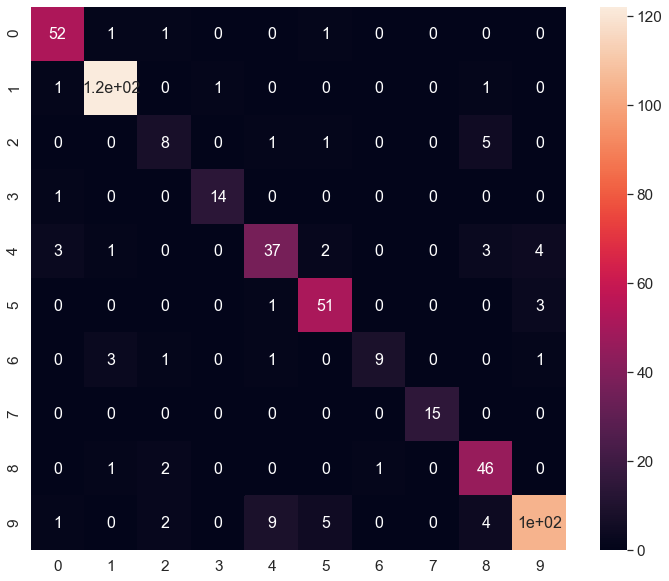


Classification report:
              precision    recall  f1-score   support

         0.0       0.90      0.95      0.92        55
         1.0       0.95      0.98      0.96       125
         2.0       0.57      0.53      0.55        15
         3.0       0.93      0.93      0.93        15
         4.0       0.76      0.74      0.75        50
         5.0       0.85      0.93      0.89        55
         6.0       0.90      0.60      0.72        15
         7.0       1.00      1.00      1.00        15
         8.0       0.78      0.92      0.84        50
         9.0       0.93      0.83      0.88       125

    accuracy                           0.88       520
   macro avg       0.86      0.84      0.84       520
weighted avg       0.88      0.88      0.88       520



In [19]:
# MLP Optimization DS2
x_train = train_data_2[ :, :-1]
y_train = train_data_2[ :, -1]

x_val = val_data_2[ :, :-1]
y_val = val_data_2[ :, -1]

x_test = labeled_test_data_2[ :, :-1]
y_test = labeled_test_data_2[ :, -1]

best = 1560

def mlp_score(layer, funct, solver):
    best_mlp = MLPClassifier(hidden_layer_sizes=layer, activation=funct, solver=solver)
    best_mlp.fit(x_train, y_train)
    pred = best_mlp.predict(x_val)
    return (y_val != pred).sum()

layers = [(30,50), (10, 10, 10)]
functions = ["logistic", "tanh", "relu", "identity"]
solvers = ["sgd", "adam"]

tuned_layers = None
tuned_function = None
tuned_solver = None

for layer in layers:
    for function in functions:
        for solver in solvers:
            missed = mlp_score(layer, function, solver)
            if missed < best:
                print(f'Layers: {layer}\n'
                      f'Activation Function: {function}\n'
                      f'Solver: {solver}')
                tuned_layers = layer
                tuned_function = function
                tuned_solver = solver
                best = missed
                print(f'Accuracy: {100-(100*missed/1560)}%')
            
tuned = MLPClassifier(hidden_layer_sizes=tuned_layers, activation=tuned_function, solver=tuned_solver)

prediction = tuned.fit(x_train, y_train).predict(x_test)
print(f'\n\nAccuracy: {100*((y_test == prediction).sum()/len(y_test))}%')

      
# write classification report
clsf_report = pd.DataFrame(classification_report(y_test, prediction, output_dict=True)).transpose()
clsf_report.to_csv('output/Best-MLP-DS2.csv', index= True)

# write the predictions
with open('output/Best-MLP-DS2.csv', 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for entry in range(prediction.size):
        writer.writerow([entry, int(prediction[entry])])
        
# get confusion matrix
labels = list(data_2.keys())
array = confusion_matrix(y_test, prediction, labels)
# append confusion matrix
with open("output/Best-MLP-DS2.csv", "a") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(array)
    

#Plot confusion matrix: evaluates the quality of the output of the classifier
print("\n" + "Confusion matrix:")
df_cm = pd.DataFrame(array, range(10), range(10))
plt.figure(figsize=(12,10))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()
           
# show precision, recall, f1-score, etc
print("\n" + "Classification report:")
BestMLP2Report = classification_report(y_test, prediction)
print(BestMLP2Report)
BestMLP2Report = classification_report(y_test, prediction, output_dict=True)

# Experiment findings

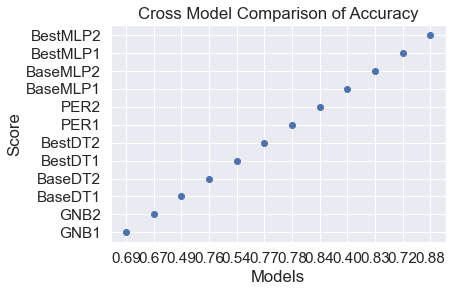

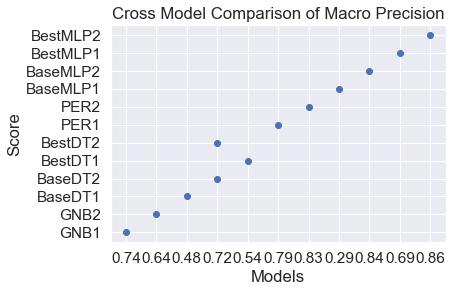

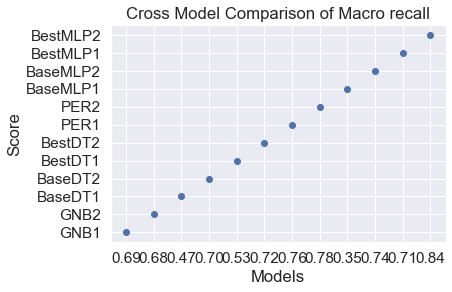

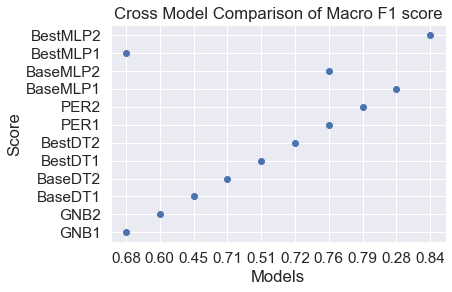

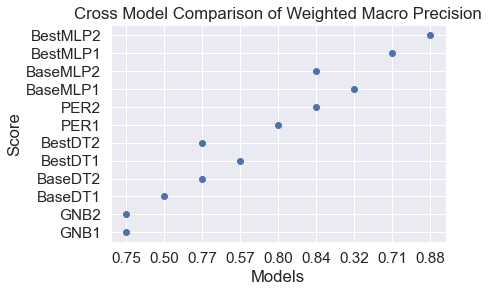

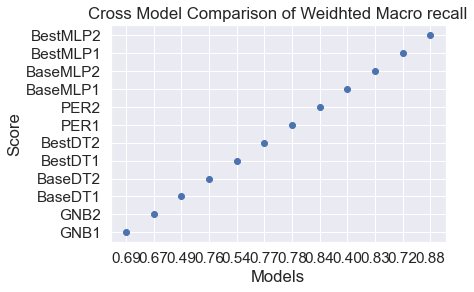

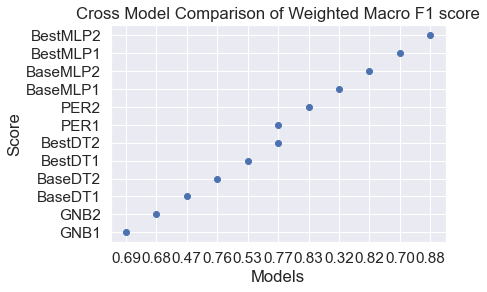

In [20]:
reports = [("GNB1",GNB1Report), ("GNB2", GNB2Report), 
           ("BaseDT1", BaseDT1Report), ("BaseDT2", BaseDT2Report),
           ("BestDT1", BestDT1Report), ("BestDT2", BestDT2Report),
           ("PER1", PER1Report), ("PER2", PER2Report),
           ("BaseMLP1", BaseMLP1Report), ("BaseMLP2", BaseMLP2Report),
           ("BestMLP1", BestMLP1Report), ("BestMLP2", BestMLP2Report)]

accuracy = [(model[0], "{:.2f}".format(model[1]['accuracy'])) for model in reports]

macro_precision = [(model[0], "{:.2f}".format(model[1]['macro avg']['precision'])) for model in reports]
macro_recall = [(model[0], "{:.2f}".format(model[1]['macro avg']['recall'])) for model in reports]
macro_f1 = [(model[0], "{:.2f}".format(model[1]['macro avg']['f1-score'])) for model in reports]

w_macro_precision = [(model[0], "{:.2f}".format(model[1]['weighted avg']['precision'])) for model in reports]
w_macro_recall = [(model[0], "{:.2f}".format(model[1]['weighted avg']['recall'])) for model in reports]
w_macro_f1 = [(model[0], "{:.2f}".format(model[1]['weighted avg']['f1-score'])) for model in reports]

def compare(report, name):
    data_x = [x[1] for x in report]
    data_y = [y[0] for y in report]
    
    plt.scatter(data_x, data_y)
    plt.xlabel("Models")
    plt.ylabel("Score")
    plt.title("Cross Model Comparison of "+name)
    plt.show()
    
# Accuracy
compare(accuracy, "Accuracy")

# Macro
compare(macro_precision, "Macro Precision")
compare(macro_recall, "Macro recall")
compare(macro_f1, "Macro F1 score")

# Weighted
compare(w_macro_precision, "Weighted Macro Precision")
compare(w_macro_recall, "Weidhted Macro recall")
compare(w_macro_f1, "Weighted Macro F1 score")